# RNN applied to the GNAN Dataset 


In [1]:
import scipy.io
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the .mat files
mat_invol = scipy.io.loadmat('dataset/epochs_blinks_ASR_invol.mat')
mat_vol = scipy.io.loadmat('dataset/epochs_blinks_ASR_vol.mat')

# Extract the data from the .mat files
data_invol = mat_invol['epochs_blinks_ASR_invol']
data_vol = mat_vol['epochs_blinks_ASR_vol']

# Number of features ('FP1' and 'FP2'), time steps and samples
n_features = data_invol.shape[0]
n_timesteps = data_invol.shape[1]
n_samples_invol = data_invol.shape[2]
n_samples_vol = data_vol.shape[2]

# Reshape the data to be of size (samples, timesteps, features)
data_invol = np.transpose(data_invol, (2, 1, 0))
data_vol = np.transpose(data_vol, (2, 1, 0))

# Create labels for the involuntary (0) and voluntary (1) data
labels_invol = np.zeros((n_samples_invol, 1))
labels_vol = np.ones((n_samples_vol, 1))

# Combine the involuntary and voluntary data and labels
X = np.concatenate((data_invol, data_vol), axis=0)
y = np.concatenate((labels_invol, labels_vol), axis=0)


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Bidirectional
from keras.layers import MaxPooling1D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Split the data into training and temporary sets (70% training, 30% temporary)
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, shuffle=True)

# Split the temporary set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [26]:
from keras.optimizers import Adam
# Define the model
model = Sequential()

# Convolutional layer
model.add(Conv1D(128, 3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(3))

# Batch normalization layer
model.add(BatchNormalization())

# LSTM layer
model.add(Bidirectional(LSTM(25, return_sequences=True)))  # Bidirectional LSTM layer with 50 units

# Dropout for regularization
model.add(Dropout(0.5))

# LSTM layer
model.add(Bidirectional(LSTM(75)))  # Another Bidirectional LSTM layer with 50 units

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  

learning_rate = 0.005  # Set the learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Test the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Epoch 1/50
40/40 [==============================] - 8s 87ms/step - loss: 0.6810 - accuracy: 0.5528 - val_loss: 0.6862 - val_accuracy: 0.5441
Epoch 2/50
40/40 [==============================] - 2s 53ms/step - loss: 0.6852 - accuracy: 0.5339 - val_loss: 0.7158 - val_accuracy: 0.5221
Epoch 3/50
40/40 [==============================] - 2s 52ms/step - loss: 0.6614 - accuracy: 0.5795 - val_loss: 0.7132 - val_accuracy: 0.5294
Epoch 4/50
40/40 [==============================] - 2s 52ms/step - loss: 0.6602 - accuracy: 0.5827 - val_loss: 0.6886 - val_accuracy: 0.5074
Epoch 5/50
40/40 [==============================] - 2s 53ms/step - loss: 0.6622 - accuracy: 0.6031 - val_loss: 0.6996 - val_accuracy: 0.5662
Epoch 6/50
40/40 [==============================] - 2s 52ms/step - loss: 0.6515 - accuracy: 0.6173 - val_loss: 0.6814 - val_accuracy: 0.5147
Epoch 7/50
40/40 [==============================] - 2s 53ms/step - loss: 0.6356 - accuracy: 0.6331 - val_loss: 0.6706 - val_accuracy: 0.5809
Epoch 8/50
40

5/5 [==============================] - 1s 19ms/step


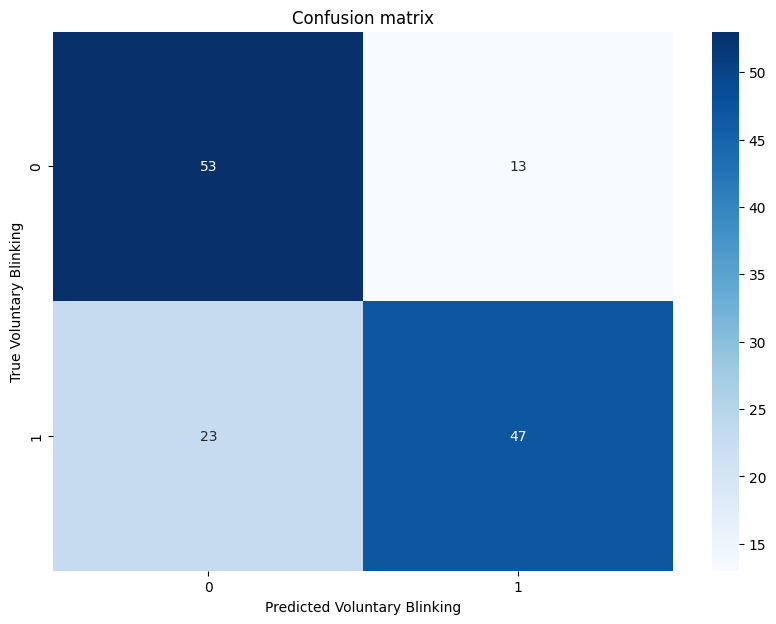

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import argmax

# predict the values from the test dataset
y_pred = model.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # transform probabilities into binary outputs

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion matrix')
plt.xlabel('Predicted Voluntary Blinking')
plt.ylabel('True Voluntary Blinking')
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75        66
         1.0       0.78      0.67      0.72        70

    accuracy                           0.74       136
   macro avg       0.74      0.74      0.73       136
weighted avg       0.74      0.74      0.73       136



In [29]:
import numpy as np
from scipy import signal

def calculate_psd(data, Fs):
    """
    Calculate the power spectral density (PSD) for EEG data.

    Parameters:
    - data: array-like, EEG data with shape (channels, points, trials)
    - Fs: int, the sampling frequency

    Returns:
    - psds: array-like, PSDs with shape (channels, frequencies, trials)
    - freqs: array-like, frequencies for which the PSDs were computed
    """
    # Initialize array to store the PSDs
    psds = []

    # Loop over the channels
    for channel_data in data:
        # Loop over the trials
        channel_psds = []
        for trial_data in channel_data.T:
            # Calculate the PSD using Welch's method
            freqs, psd = signal.welch(trial_data, Fs)
            channel_psds.append(psd)
        psds.append(channel_psds)
    
    return np.array(psds), freqs

In [30]:
# Extract the data from the .mat files
data_invol = mat_invol['epochs_blinks_ASR_invol']
data_vol = mat_vol['epochs_blinks_ASR_vol']

Fs=250; #sample frequency
# Calculate the PSDs of the GNAN data
psds_invol, freqs = calculate_psd(data_invol, Fs)
psds_vol, _ = calculate_psd(data_vol, Fs)

# Number of features ('FP1' and 'FP2'), time steps and samples
n_features = psds_invol.shape[0]
n_timesteps = psds_invol.shape[2]
n_samples_invol = psds_invol.shape[1]
n_samples_vol = psds_vol.shape[1]

# Reshape the data to be of size (samples, timesteps, features)
psds_invol = np.transpose(psds_invol, (1, 2, 0))
psds_vol = np.transpose(psds_vol, (1, 2, 0))

# Create labels for the involuntary (0) and voluntary (1) data
labels_invol = np.zeros((n_samples_invol, 1))
labels_vol = np.ones((n_samples_vol, 1))

# Combine the involuntary and voluntary data and labels
X = np.concatenate((psds_invol, psds_vol), axis=0)
y = np.concatenate((labels_invol, labels_vol), axis=0)

In [31]:
# Split the data into training and temporary sets (70% training, 30% temporary)
X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, shuffle=True)

# Split the temporary set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [39]:
# Define the model
model = Sequential()

# Convolutional layer
model.add(Conv1D(128, 3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(3))

# Batch normalization layer
model.add(BatchNormalization())

# LSTM layer
model.add(Bidirectional(LSTM(25, return_sequences=True)))  # Bidirectional LSTM layer with 50 units

# Dropout for regularization
model.add(Dropout(0.4))

# LSTM layer
model.add(Bidirectional(LSTM(75)))  # Another Bidirectional LSTM layer with 50 units

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  

learning_rate = 0.0025999  # Set the learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

# Test the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Epoch 1/50
40/40 [==============================] - 13s 182ms/step - loss: 0.6773 - accuracy: 0.5496 - val_loss: 0.6826 - val_accuracy: 0.4853
Epoch 2/50
40/40 [==============================] - 6s 140ms/step - loss: 0.6644 - accuracy: 0.6016 - val_loss: 0.7126 - val_accuracy: 0.5147
Epoch 3/50
40/40 [==============================] - 5s 137ms/step - loss: 0.6648 - accuracy: 0.5795 - val_loss: 0.6962 - val_accuracy: 0.5294
Epoch 4/50
40/40 [==============================] - 4s 110ms/step - loss: 0.6555 - accuracy: 0.6252 - val_loss: 0.6955 - val_accuracy: 0.5441
Epoch 5/50
40/40 [==============================] - 4s 105ms/step - loss: 0.6535 - accuracy: 0.6047 - val_loss: 0.7673 - val_accuracy: 0.5368
Epoch 6/50
40/40 [==============================] - 4s 106ms/step - loss: 0.6430 - accuracy: 0.6378 - val_loss: 0.7478 - val_accuracy: 0.5294
Epoch 7/50
40/40 [==============================] - 4s 105ms/step - loss: 0.6402 - accuracy: 0.6299 - val_loss: 0.6997 - val_accuracy: 0.5588
Epoch

5/5 [==============================] - 1s 45ms/step


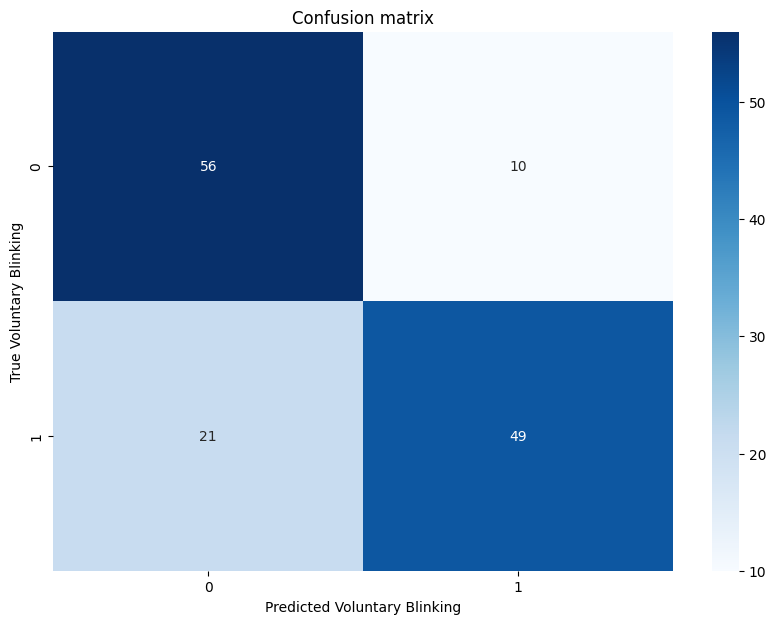

In [40]:
# predict the values from the test dataset
y_pred = model.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # transform probabilities into binary outputs

# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion matrix')
plt.xlabel('Predicted Voluntary Blinking')
plt.ylabel('True Voluntary Blinking')
plt.show()

In [41]:
# Generate the classification report
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

         0.0       0.73      0.85      0.78        66
         1.0       0.83      0.70      0.76        70

    accuracy                           0.77       136
   macro avg       0.78      0.77      0.77       136
weighted avg       0.78      0.77      0.77       136

